Join the data from Part 1 with the data from Part 2 to create a new dataframe.

In [3]:
import pandas as pd
import geopy # to retreive the postal code from latitude and longitude
import sqlite3
import os
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

bikes_df = pd.read_csv('bikes.csv', index_col=0)
FSQ_df = pd.read_csv('fsq.csv', index_col =0)
yelp_df = pd.read_csv('yelp.csv', index_col = 0)


In [64]:
#bikes_df.head()
#FSQ_df.head()
#yelp_df.head()

,latitude,longitude,free_bikes
0,43.665269,-79.319796,16
1,43.671420,-79.445947,0
2,43.666224,-79.317693,21
3,43.653236,-79.376716,0
4,43.663722,-79.380288,8


In [4]:
def get_postCode(df,lat, long): # function to retreive the postal code
    geo = geopy.Nominatim(user_agent='1234')
    location = geo.reverse((df[lat], df[long]))
    postCode = location[0].split(',')[-2]
    return postCode
bikes_df['postCode']= bikes_df.apply(get_postCode, axis=1, long='longitude',lat='latitude')

In [5]:
bikes_df.head()

,latitude,longitude,free_bikes,postCode
0,43.665269,-79.319796,16,M4L 1E2
1,43.671420,-79.445947,0,M6H 2C7
2,43.666224,-79.317693,21,M4L 3B2
3,43.653236,-79.376716,0,M5C 1R8
4,43.663722,-79.380288,8,M4Y 1X7


In [6]:
# remove the space between the words in the postal code

bikes_df['postCode'] = bikes_df['postCode'].str.strip()
bikes_df['postCode']= bikes_df['postCode'].str.split().agg("".join)

FSQ_df['postCode'] = FSQ_df['postCode'].str.strip()
FSQ_df['postCode']= FSQ_df['postCode'].str.split().agg("".join)

yelp_df['postCode'] = yelp_df['postCode'].str.strip()
yelp_df['postCode']= yelp_df['postCode'].str.split().agg("".join)



In [7]:
# 46 rows have no full postal code in bikee_df.
len(bikes_df[bikes_df['postCode'].str.len() < 4])

# zero rows have no full postal code in FSQ_df
len(FSQ_df[FSQ_df['postCode'].str.len() < 4])

#196 rows have no full postal code out of 8061 rows in yelp_df
len(yelp_df[yelp_df['postCode'].str.len() < 4])

# drop the rows that have no full postal code
bikes_df.drop(bikes_df[bikes_df['postCode'].str.len() < 4].index, inplace=True)
yelp_df.drop(yelp_df[yelp_df['postCode'].str.len() < 4].index, inplace=True) 

In [23]:
join_df = pd.merge(pd.merge(bikes_df,FSQ_df, on='postCode'),yelp_df, on='postCode')
join_df.head()
#len(join_df)

,latitude_x,longitude_x,free_bikes,postCode,POI_x,latitude_y,longitude_y,address,city_x,POI_y,rating,category1,category2,latitude,longitude,price,city_y,street
0,43.665269,-79.319796,16,M4L1E2,Diner,43.665121,-79.321347,"1483 Queen St E, Toronto ON M4L 1E2",Toronto,Chick-N-Joy,4.0,hotdogs,Fast Food,43.665090,-79.32132,$,Toronto,1483 Queen Street E
1,43.665269,-79.319796,16,M4L1E2,Diner,43.665121,-79.321347,"1483 Queen St E, Toronto ON M4L 1E2",Toronto,Chick-N-Joy,4.0,hotdogs,Fast Food,43.665090,-79.32132,$,Toronto,1483 Queen Street E
2,43.667214,-79.345270,14,M4M1Y5,Chinese Restaurant,43.666856,-79.345563,"797 Gerrard St E (at Logan Ave), Toronto ON M4...",Toronto,Hailed Coffee,4.5,coffee,Coffee & Tea,43.666880,-79.34538,$$,Toronto,801 Gerrard Street E
3,43.667214,-79.345270,14,M4M1Y5,Chinese Restaurant,43.666856,-79.345563,"797 Gerrard St E (at Logan Ave), Toronto ON M4...",Toronto,Hailed Coffee,4.5,coffee,Coffee & Tea,43.666880,-79.34538,$$,Toronto,801 Gerrard Street E
4,43.680916,-79.422968,6,M6G2N3,Ice Cream Parlor,43.682023,-79.419025,36 Vaughan Rd (btwn Ellsworth Ave. & Hocken Av...,Toronto,Dutch Dreams,4.0,icecream,Ice Cream & Frozen Yogurt,43.682045,-79.41892,$$,Toronto,36 Vaughan Road


In [24]:
# remove duplicate rows, before 51677 rows / after 1333 rows
join_df.drop_duplicates(inplace=True)
join_df.head()

,latitude_x,longitude_x,free_bikes,postCode,POI_x,latitude_y,longitude_y,address,city_x,POI_y,rating,category1,category2,latitude,longitude,price,city_y,street
0,43.665269,-79.319796,16,M4L1E2,Diner,43.665121,-79.321347,"1483 Queen St E, Toronto ON M4L 1E2",Toronto,Chick-N-Joy,4.0,hotdogs,Fast Food,43.665090,-79.32132,$,Toronto,1483 Queen Street E
2,43.667214,-79.345270,14,M4M1Y5,Chinese Restaurant,43.666856,-79.345563,"797 Gerrard St E (at Logan Ave), Toronto ON M4...",Toronto,Hailed Coffee,4.5,coffee,Coffee & Tea,43.666880,-79.34538,$$,Toronto,801 Gerrard Street E
4,43.680916,-79.422968,6,M6G2N3,Ice Cream Parlor,43.682023,-79.419025,36 Vaughan Rd (btwn Ellsworth Ave. & Hocken Av...,Toronto,Dutch Dreams,4.0,icecream,Ice Cream & Frozen Yogurt,43.682045,-79.41892,$$,Toronto,36 Vaughan Road
28,43.691067,-79.395350,0,M4T2S9,Fried Chicken Joint,43.689827,-79.395102,"1560 Yonge St (Heath St E), Toronto ON M4T 2S9",Toronto,Sushi Gen,3.0,sushi,Sushi Bars,43.689908,-79.39514,$$,Toronto,1560 Yonge Street
32,43.639832,-79.395954,29,M5V4A6,Café,43.640050,-79.396376,"66 Fort York Blvd (Fort York & Spadina), Toron...",Toronto,Hunters Landing,3.5,comfortfood,Comfort Food,43.640020,-79.39673,$$,Toronto,82 Fort York Blvd


In [25]:
#join_df.head()
join_df.columns
#join_df.city_y.unique()

Index(['latitude_x', 'longitude_x', 'free_bikes', 'postCode', 'POI_x',
       'latitude_y', 'longitude_y', 'address', 'city_x', 'POI_y', 'rating',
       'category1', 'category2', 'latitude', 'longitude', 'price', 'city_y',
       'street'],
      dtype='object')

In [26]:
#drop the unuseful columns
join_df.drop(['latitude_x', 'longitude_x', 'latitude_y','longitude_y','latitude','longitude','address'], axis=1, inplace=True)

In [27]:
#there are some difference between city_x and city_y columns, 181 rows

city_df = join_df.loc[join_df.city_x != join_df.city_y]
city_df[['city_x', 'city_y','street']]
len(city_df)

51

In [28]:
# update the city with the accurate city, e.g instead of Toronto, use East York

#tor_df = join_df.loc[join_df.city_x =='East York']
#tor_df[['city_x', 'city_y', 'address','street']]
join_df['city_x'] = join_df.apply(lambda x:x['city_y'] if x['city_x']=='Toronto' else x['city_x'], axis=1)
join_df['city_y'] = join_df.apply(lambda x:x['city_x'] if x['city_y']=='Toronto' else x['city_y'], axis=1)
join_df['city_y'].unique()

array(['Toronto', 'East York', 'Etobicoke', 'York', 'North York',
       'Aurora'], dtype=object)

In [29]:
# drop city_y, address columns and update the city and POI column names

join_df = join_df.rename({'city_x': 'city', 'POI_x': 'FSQ_POI', 'POI_y':'yelp_POI', 'category1':'category'}, axis=1)
join_df.drop(['city_y'], axis=1, inplace=True)
join_df.head()



,free_bikes,postCode,FSQ_POI,city,yelp_POI,rating,category,category2,price,street
0,16,M4L1E2,Diner,Toronto,Chick-N-Joy,4.0,hotdogs,Fast Food,$,1483 Queen Street E
2,14,M4M1Y5,Chinese Restaurant,Toronto,Hailed Coffee,4.5,coffee,Coffee & Tea,$$,801 Gerrard Street E
4,6,M6G2N3,Ice Cream Parlor,Toronto,Dutch Dreams,4.0,icecream,Ice Cream & Frozen Yogurt,$$,36 Vaughan Road
28,0,M4T2S9,Fried Chicken Joint,Toronto,Sushi Gen,3.0,sushi,Sushi Bars,$$,1560 Yonge Street
32,29,M5V4A6,Café,Toronto,Hunters Landing,3.5,comfortfood,Comfort Food,$$,82 Fort York Blvd


In [30]:
# remove number from street columns

join_df['street'] = join_df['street'].replace('\d+','', regex=True)
join_df.head()

,free_bikes,postCode,FSQ_POI,city,yelp_POI,rating,category,category2,price,street
0,16,M4L1E2,Diner,Toronto,Chick-N-Joy,4.0,hotdogs,Fast Food,$,Queen Street E
2,14,M4M1Y5,Chinese Restaurant,Toronto,Hailed Coffee,4.5,coffee,Coffee & Tea,$$,Gerrard Street E
4,6,M6G2N3,Ice Cream Parlor,Toronto,Dutch Dreams,4.0,icecream,Ice Cream & Frozen Yogurt,$$,Vaughan Road
28,0,M4T2S9,Fried Chicken Joint,Toronto,Sushi Gen,3.0,sushi,Sushi Bars,$$,Yonge Street
32,29,M5V4A6,Café,Toronto,Hunters Landing,3.5,comfortfood,Comfort Food,$$,Fort York Blvd


In [31]:
# put price in different categories [Inexpensive, Moderately, Expensive, Very Expensive] 

join_df.loc[join_df['price'] == '$', 'price'] = 'Inexpensive'
join_df.loc[join_df['price'] == '$$', 'price'] = 'Moderately'
join_df.loc[join_df['price'] == '$$$', 'price'] = 'Expensive'
join_df.loc[join_df['price'] == '$$$$', 'price'] = 'Very Expensive'

join_df.head()

,free_bikes,postCode,FSQ_POI,city,yelp_POI,rating,category,category2,price,street
0,16,M4L1E2,Diner,Toronto,Chick-N-Joy,4.0,hotdogs,Fast Food,Inexpensive,Queen Street E
2,14,M4M1Y5,Chinese Restaurant,Toronto,Hailed Coffee,4.5,coffee,Coffee & Tea,Moderately,Gerrard Street E
4,6,M6G2N3,Ice Cream Parlor,Toronto,Dutch Dreams,4.0,icecream,Ice Cream & Frozen Yogurt,Moderately,Vaughan Road
28,0,M4T2S9,Fried Chicken Joint,Toronto,Sushi Gen,3.0,sushi,Sushi Bars,Moderately,Yonge Street
32,29,M5V4A6,Café,Toronto,Hunters Landing,3.5,comfortfood,Comfort Food,Moderately,Fort York Blvd


In [32]:
# Categories

join_df.loc[join_df['category'].isin(['sushi', 'japanese', 'thai', 'korean','chinese', 'vietnamese','dimsum', 'asianfusion', 'noodles', 'indpak', 'ramen', 'himalayan']), 'category'] = 'Asian'
join_df.loc[join_df['category'].isin(['mediterranean', 'mideastern', 'lebanese']), 'category'] = 'MiddleEast'
join_df.loc[join_df['category'].isin(['french', 'portuguese' , 'greek', 'polish', 'russian','italian', 'tapas']), 'category'] = 'Europe'
join_df.loc[join_df['category'].isin(['peruvian', 'mexican','caribbean', 'cuban', 'newcanadian', 'latin', 'hawaiian']), 'category'] = 'American'
join_df.loc[join_df['category'].isin(['pizza', 'bagels', 'burgers', 'chicken_wings','sandwiches', 'hotdogs','icecream','bakeries','comfortfood','vegan','salad','breakfast_brunch','seafood','chickenshop','diners','tapasmallplates','delis']), 'category'] = 'FastFood'
join_df.loc[join_df['category'].isin(['cafes', 'coffeeroasteries', 'coffee','chocolate','desserts',]), 'category'] = 'Cafe'
join_df.loc[join_df['category'].isin(['pubs', 'gastropubs', 'cocktailbars', 'wine_bars', 'bars', 'beer_and_wine', 'breweries','lounges','tikibars']), 'category'] = 'Bars'
join_df.loc[join_df['category'].isin(['steak','bbq','dinnertheater','venues']), 'category'] = 'Fancy'
join_df.loc[join_df['category'].isin(['ethiopian']), 'category'] = 'African'


In [33]:
# drop unusful columns

join_df.drop(['category2', 'FSQ_POI', 'yelp_POI'], axis=1, inplace=True)
join_df.head()

,free_bikes,postCode,city,rating,category,price,street
0,16,M4L1E2,Toronto,4.0,FastFood,Inexpensive,Queen Street E
2,14,M4M1Y5,Toronto,4.5,Cafe,Moderately,Gerrard Street E
4,6,M6G2N3,Toronto,4.0,FastFood,Moderately,Vaughan Road
28,0,M4T2S9,Toronto,3.0,Asian,Moderately,Yonge Street
32,29,M5V4A6,Toronto,3.5,FastFood,Moderately,Fort York Blvd


Provide a visualization that you used as part of your EDA process. Explain the initial pattern or relationship you discoved through this visualization. 

In [34]:
# convert categorical variables to numeric
join_df.price = pd.Categorical(join_df.price)
join_df.city = pd.Categorical(join_df.city)
join_df.category = pd.Categorical(join_df.category)
join_df.street = pd.Categorical(join_df.street)
join_df.postCode = pd.Categorical(join_df.postCode)


join_df['price_c'] = join_df.price.cat.codes
join_df['city_c'] = join_df.city.cat.codes
join_df['category_c'] = join_df.category.cat.codes
join_df['street_c'] = join_df.street.cat.codes
join_df['postCode_c'] = join_df.postCode.cat.codes



#join_df['price'].replace(['Inexpensive', 'Moderately','Expensive','Very Expensive'],[1,2,3,4], inplace=True)
#join_df['city'].replace(['Toronto', 'North York','Aurora','Etobicoke','East York','York '],[1,2,3,4,5,6], inplace=True)
#join_df['category'].replace(['FastFood', 'Cafe','Europe','Asian','American','Bars','Fancy','MiddleEast'],[1,2,3,4,5,6,7,8], inplace=True)

In [35]:
join_df.head()

,free_bikes,postCode,city,rating,category,price,street,price_c,city_c,category_c
0,16,M4L1E2,Toronto,4.0,FastFood,Inexpensive,Queen Street E,1,4,7
2,14,M4M1Y5,Toronto,4.5,Cafe,Moderately,Gerrard Street E,2,4,4
4,6,M6G2N3,Toronto,4.0,FastFood,Moderately,Vaughan Road,2,4,7
28,0,M4T2S9,Toronto,3.0,Asian,Moderately,Yonge Street,2,4,2
32,29,M5V4A6,Toronto,3.5,FastFood,Moderately,Fort York Blvd,2,4,7


In [36]:
# remove street with < 4 businesses

new= join_df.groupby('street')['street'].count() 
street = list(new[new < 4].index)
street

[' -  Leslie Street',
 ' / Queen Street W',
 ' A Danforth Avenue',
 ' Bay St',
 ' Bloor St East',
 ' Bloor Street  W',
 ' Bremner Boulevard',
 ' Carlton Street',
 ' College Street',
 ' Dundas Street E',
 ' Front Street E',
 ' Front Street W',
 ' Hart House Circle',
 ' Lake Shore Boulevard W',
 ' Lakeview Avenue',
 ' Lower Simcoe Street',
 ' McCaul Street',
 ' Oakwood Avenue',
 ' Queens Quay W',
 ' Richmond St W',
 ' Richmond Street W',
 ' Rushton Rd',
 ' Saint Clair Avenue W',
 ' Spadina ave',
 ' St Clair Ave W',
 ' The Esplanade',
 ' The Queensway',
 ' Vaughan Road',
 ' Victoria Street',
 ' Wellington Street  W',
 ' Yonge St']

In [37]:
join_df.drop(join_df[join_df['street'].isin(street)].index, inplace=True)
len(join_df)

1648

In [80]:
# remove postal code with < 4 businesses

new= join_df.groupby('postCode')['postCode'].count() 
#postcode = list(new[new < 4].index)
#postcode
new.sort_values(ascending=False)

postCode
M5A3C4    1020
M6K3C3      96
M3J1P3      60
M4N3M5      56
M4G3B7      48
M4C1M1      42
M4C1L7      20
M3J3K2      18
M4M1J3      16
M4C1J4      15
M4J1L9      12
M8Y2R3      12
M6H1N7      12
M6R2N1      10
M4K1R1       9
M5P2W3       9
M6J1H9       8
M5V4A6       8
M5V1E3       8
M5T1L1       7
M5S1W7       6
M6R1A8       6
M6R2M9       6
M5R1V7       6
M5A1A4       6
M4M1L5       6
M4M1Y2       6
M5S1X8       4
M6J2Z4       4
M4J1L1       4
M4K1P8       4
M6K3C5       4
M4N2L2       4
M6K1M2       4
M6J1V9       4
M5N1A2       4
M4N2M8       4
M6J1G6       4
M4S3C4       4
M6G1L3       4
M6E1B5       4
M5B2A2       4
M9N1W2       4
M6G1M4       2
Name: postCode, dtype: int64

In [39]:
join_df.drop(join_df[join_df['postCode'].isin(postcode)].index, inplace=True)
len(join_df)

1596

In [40]:
join_df['street'].value_counts()
join_df['postCode'].value_counts()
join_df['category'].value_counts()
join_df['price'].value_counts()
join_df['city'].value_counts()

city
Toronto       1546
North York      21
Aurora          15
Etobicoke        8
East York        4
York             2
Name: count, dtype: int64

In [42]:
# we can remove city column almost 97% of the businesses in Tornoto, will rely on the postal code only

join_df.drop(['city_c', 'city'], axis=1, inplace =True)
join_df.head()

,free_bikes,postCode,rating,category,price,street,price_c,category_c
32,29,M5V4A6,3.5,FastFood,Moderately,Fort York Blvd,2,7
38,29,M5V4A6,4.5,Cafe,Moderately,Fort York Boulevard,2,4
43,29,M5V4A6,3.5,FastFood,Moderately,Fort York Blvd,2,7
49,29,M5V4A6,4.5,Cafe,Moderately,Fort York Boulevard,2,4
54,29,M5V4A6,3.5,FastFood,Moderately,Fort York Blvd,2,7


In [45]:
join_df.describe()

,free_bikes,rating,price_c,category_c,street_c,postCode_c
count,1596.000000,1596.000000,1596.000000,1596.000000,1596.000000,1596.000000
mean,5.216792,3.727444,1.298246,4.676692,24.471805,17.929198
std,4.555543,0.513112,0.876741,2.026343,10.381311,8.772606
min,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,3.500000,0.000000,3.000000,19.000000,18.000000
50%,4.000000,4.000000,2.000000,5.000000,32.000000,18.000000
75%,9.000000,4.000000,2.000000,7.000000,33.000000,18.000000
max,29.000000,5.000000,2.000000,8.000000,39.000000,43.000000


In [46]:
join_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1596 entries, 32 to 52066
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   free_bikes  1596 non-null   int64   
 1   postCode    1596 non-null   category
 2   rating      1596 non-null   float64 
 3   category    1596 non-null   category
 4   price       1596 non-null   category
 5   street      1596 non-null   category
 6   price_c     1596 non-null   int8    
 7   category_c  1596 non-null   int8    
 8   street_c    1596 non-null   int8    
 9   postCode_c  1596 non-null   int8    
dtypes: category(4), float64(1), int64(1), int8(4)
memory usage: 53.2 KB


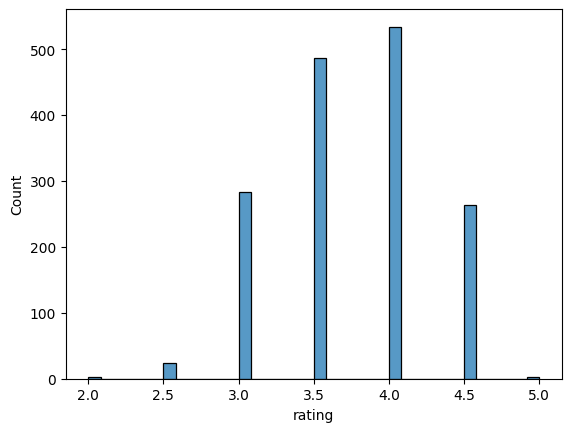

In [47]:
# Numeric value distribution
sns.histplot(join_df['rating'])
plt.show()
# skewed to the left

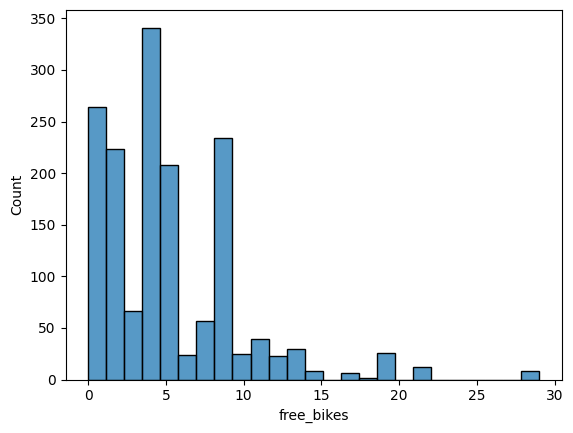

In [48]:
sns.histplot(join_df['free_bikes'])
plt.show()
# skewed to the right

<Axes: xlabel='price_c', ylabel='count'>

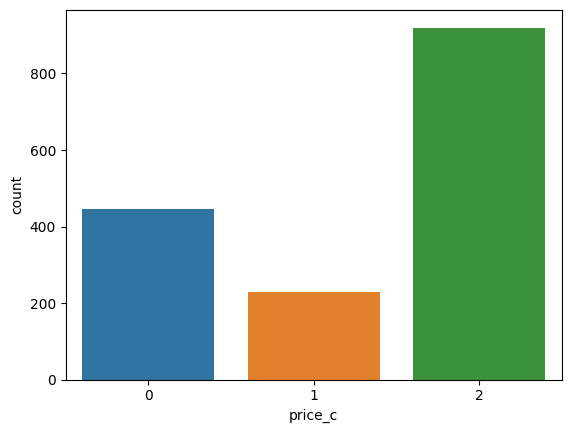

In [60]:
sns.countplot(x='price_c', data=join_df)

In [50]:
# Shapiro-Wilk's normality test
stat, p = stats.shapiro(join_df['rating'])
#print(p)
if p > 0.05:
    print ('%0.60f' % p, '\nNormally distributed')
else: 
    print ('%0.60f' % p, '\nReject the H0, not normally distributed')
#print('%0.60f' % p)

0.000000000000000000000000000001558406087269311782492514851786 
Reject the H0, not noramlly distributed


In [51]:
# Shapiro-Wilk's normality test

stat, p = stats.shapiro(join_df['free_bikes'])
#print(p)
if p > 0.05:
    print ('%0.60f' % p, '\n normally distributed')
else: 
    print ('%0.60f' % p, '\nReject the H0, not noramlly distributed')
#print('%0.60f' % p)

0.000000000000000000000000000000000005434516152760014148397871 
Reject the H0, not noramlly distributed


In [61]:
# Independence test
contingency1 = pd.crosstab(join_df['category_c'], join_df['price_c'])
contingency1

price_c,0,1,2
category_c,,,
1,85,36,24
2,0,8,143
3,0,15,105
4,113,25,189
5,91,0,191
6,62,0,0
7,89,138,262
8,6,6,6


In [58]:
join_df[join_df['category_c'] == 0]

,free_bikes,postCode,rating,category,price,street,price_c,category_c,street_c,postCode_c
47360,3,M6G1M4,3.5,African,Moderately,Bloor Street W,2,0,4,30
47367,3,M6G1M4,3.5,African,Moderately,Bloor Street W,2,0,4,30


In [59]:
# let's try to remove the African category because it's only has two items
join_df.drop(join_df[join_df['category'] == 'African'].index, inplace=True)


In [62]:
stat, p, dof, expected = stats.chi2_contingency(contingency1)
if p > 0.05:
    print ('%0.60f' % p, '\n independent')
else: 
    print (p, '\nReject the H0, not independent')

2.9303078060765243e-109 
Reject the H0, not independent


In [63]:
contingency2 = pd.crosstab(join_df['postCode_c'], join_df['price_c'])
contingency2

price_c,0,1,2
postCode_c,,,
0,0,30,30
1,0,6,12
2,0,15,0
3,0,5,15
4,0,28,14
5,6,0,42
6,0,4,0
7,0,0,12
8,0,0,4


In [64]:
stat, p, dof, expected = stats.chi2_contingency(contingency2)
if p > 0.05:
    print ('%0.60f' % p, '\n independent')
else: 
    print (p, '\nReject the H0, not independent')

5.641651669219303e-99 
Reject the H0, not independent


In [65]:
contingency3 = pd.crosstab(join_df['postCode_c'], join_df['category_c'])
contingency3

category_c,1,2,3,4,5,6,7,8
postCode_c,,,,,,,,
0,15,0,0,15,0,0,30,0
1,6,6,0,0,0,0,0,6
2,0,0,15,0,0,0,0,0
3,5,0,0,0,5,0,10,0
4,14,14,0,0,0,0,14,0
5,0,6,0,0,0,0,36,6
6,0,0,0,0,0,0,4,0
7,0,0,6,0,0,0,6,0
8,0,0,0,0,2,0,2,0


In [66]:
stat, p, dof, expected = stats.chi2_contingency(contingency3)
if p > 0.05:
    print ('%0.60f' % p, '\n independent')
else: 
    print (p, '\nReject the H0, not independent')

0.0 
Reject the H0, not independent


<Axes: xlabel='price_c', ylabel='count'>

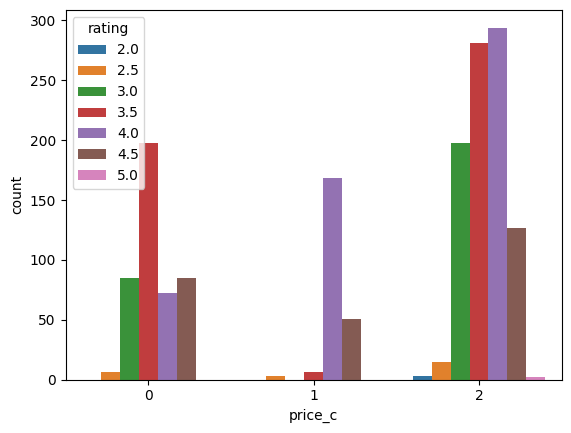

In [67]:
sns.countplot(x='price_c', hue='rating', data=join_df)

# 0 expensive : 1: inexpensive 2:moderated
# there is relation between food cost and rating, inexpesive food get high rating, while expisive food get lower rating
# I think because people expectation for services and quality get higher when they spend more money. 

In [75]:
join_df.head()

,free_bikes,postCode,rating,category,price,street,price_c,category_c,street_c,postCode_c
32,29,M5V4A6,3.5,FastFood,Moderately,Fort York Blvd,2,7,16,27
38,29,M5V4A6,4.5,Cafe,Moderately,Fort York Boulevard,2,4,17,27
43,29,M5V4A6,3.5,FastFood,Moderately,Fort York Blvd,2,7,16,27
49,29,M5V4A6,4.5,Cafe,Moderately,Fort York Boulevard,2,4,17,27
54,29,M5V4A6,3.5,FastFood,Moderately,Fort York Blvd,2,7,16,27


In [76]:
join_df.to_csv('join.csv') # export the result into csv file

# Database

Put all your results in an SQLite3 database (remember, SQLite stores its databases as files in your local machine - make sure to create your database in your project's data/ directory!)

Look at the data before and after the join to validate your data.

In [71]:
table_name = 'JoinDF'

conn = sqlite3.connect(os.path.realpath('../data/project2.db'))
query = f'Create table if not Exists {table_name} (free_bikes int, postCode text, city int, rating real, category int, price int,street text)'
conn.execute(query)

join_df.to_sql(table_name, conn, if_exists='replace', index=False)
conn.commit()
conn.close()


In [73]:
conn = sqlite3.connect(os.path.realpath('../data/project2.db'))
query2 = 'SELECT * FROM JoinDF'
cur = conn.cursor()
cur.execute(query2)
rows = cur.fetchall()

for i in rows:
    print(i)
    
conn.close()





(29, 'M5V4A6', 3.5, 'FastFood', 'Moderately', ' Fort York Blvd', 2, 7, 16, 27)
(29, 'M5V4A6', 4.5, 'Cafe', 'Moderately', ' Fort York Boulevard', 2, 4, 17, 27)
(29, 'M5V4A6', 3.5, 'FastFood', 'Moderately', ' Fort York Blvd', 2, 7, 16, 27)
(29, 'M5V4A6', 4.5, 'Cafe', 'Moderately', ' Fort York Boulevard', 2, 4, 17, 27)
(29, 'M5V4A6', 3.5, 'FastFood', 'Moderately', ' Fort York Blvd', 2, 7, 16, 27)
(29, 'M5V4A6', 4.5, 'Cafe', 'Moderately', ' Fort York Boulevard', 2, 4, 17, 27)
(29, 'M5V4A6', 3.5, 'FastFood', 'Moderately', ' Fort York Blvd', 2, 7, 16, 27)
(29, 'M5V4A6', 4.5, 'Cafe', 'Moderately', ' Fort York Boulevard', 2, 4, 17, 27)
(2, 'M5S1W7', 4.0, 'Fancy', 'Expensive', ' Bloor Street W', 0, 6, 4, 23)
(2, 'M5S1W7', 4.0, 'Fancy', 'Expensive', ' Bloor Street W', 0, 6, 4, 23)
(2, 'M5S1W7', 4.0, 'Fancy', 'Expensive', ' Bloor Street W', 0, 6, 4, 23)
(4, 'M5S1W7', 4.0, 'Fancy', 'Expensive', ' Bloor Street W', 0, 6, 4, 23)
(4, 'M5S1W7', 4.0, 'Fancy', 'Expensive', ' Bloor Street W', 0, 6, 4, 23)